In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
creditcards = pd.read_csv('data/creditcard.csv')
creditcards.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1.Проведем разведочный анализ данных

Построим матрицу корреляции

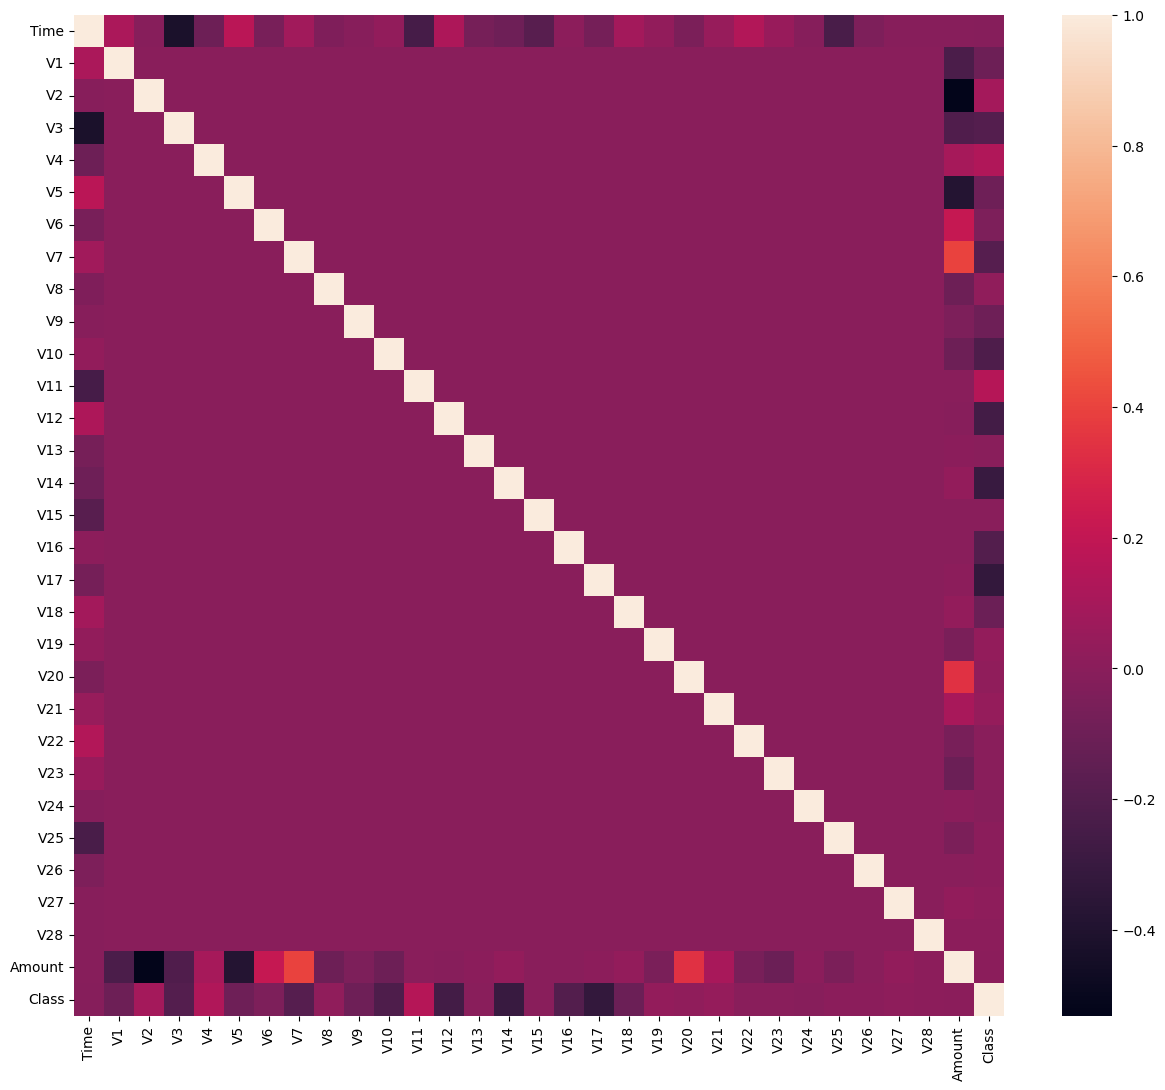

In [3]:
plt.figure(figsize = (15,13))
sns.heatmap(creditcards.corr());


Как видно из полученной матрицы, призника V1 - V28 никак не коррелируют друг с другом, но имеется незначительная корреляция этих признаков с колонками Time, Amount и с целевой переменной Class

Проверим сбалансированность классов

In [4]:
count_df = creditcards[['Time', 'Class']].groupby('Class', as_index=False).count().rename(columns={'Time':'Count_abs'})
count_df['Count_re'] = [count_df['Count_abs'].loc[i]/len(creditcards) for i in count_df.Class.unique()]
count_df


,Class,Count_abs,Count_re
0,0,284315,0.998273
1,1,492,0.001727


Из полученного датафрейма видно, что данные являются сильно несбалансированными. Более 99 % данных относятся к 0 классу

Далее выведены основные статистики по датафрейму

In [5]:
creditcards.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2.Разделим датасет на обучающую и тестовую подвыборки

In [3]:
random_state = 42


In [4]:
X_train, X_test, y_train, y_test = train_test_split(creditcards.drop('Class', axis=1), creditcards[['Class']],
                                                     test_size=0.2, random_state=random_state)


Сравним статистики исходного и получившихся датафреймов

In [8]:
abs(creditcards.drop('Class', axis=1).describe() - X_train.describe())


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,...,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,21.307902,0.000916,0.000384,0.000920,0.001458,0.000997,0.000613,0.001090,0.000383,0.000961,...,0.000398,0.000215,0.001215,0.000175,0.000217,0.000979,0.000192,0.000032,0.000257,0.130374
std,0.325709,0.000358,0.005294,0.001710,0.000015,0.007421,0.004532,0.006399,0.005710,0.001079,...,0.003120,0.001907,0.000390,0.002643,0.000201,0.000486,0.000216,0.001812,0.000307,4.810168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113912,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.670435,0.000000,0.000000
25%,40.500000,0.000455,0.000579,0.000421,0.000630,0.002795,0.000277,0.001920,0.000199,0.000711,...,0.000248,0.000335,0.000459,0.000550,0.000300,0.000690,0.000492,0.000120,0.000020,0.000000
50%,15.000000,0.000131,0.000565,0.000806,0.001112,0.000376,0.000659,0.001169,0.000125,0.001015,...,0.000133,0.000189,0.001291,0.000598,0.000210,0.001493,0.000128,0.000017,0.000122,0.000000
75%,15.500000,0.000094,0.000174,0.001796,0.001711,0.000754,0.002509,0.000203,0.000158,0.001901,...,0.000024,0.000297,0.001146,0.000560,0.000263,0.000263,0.000139,0.000355,0.000184,0.065000
max,0.000000,0.000000,0.000000,5.194748,0.000000,0.000000,0.000000,0.000000,0.000000,5.202106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
abs(creditcards.drop('Class', axis=1).describe() - X_test.describe())


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,85.230485,0.003663,0.001537,0.003680,0.005833,0.003986,0.002452,0.004358,0.001533,0.003846,...,0.001590,0.000862,0.004862,0.000699,0.000868,0.003917,0.000766,0.000128,0.001029,0.521488
std,0.981610,0.001446,0.021333,0.006828,0.000059,0.030085,0.018277,0.025933,0.022582,0.004306,...,0.012602,0.007586,0.001545,0.010681,0.000809,0.001963,0.000863,0.007171,0.001225,20.243361
min,0.000000,22.259276,24.654872,14.644605,0.123054,90.073581,5.290880,2.050445,22.796628,0.000000,...,32.963899,11.941035,2.046127,11.978740,0.011778,1.598770,0.535990,0.000000,3.719188,0.000000
25%,121.750000,0.001613,0.002284,0.001661,0.002761,0.010752,0.001068,0.006078,0.000477,0.003111,...,0.001015,0.001276,0.001582,0.002298,0.001311,0.002916,0.002226,0.000573,0.000100,0.010000
50%,21.500000,0.000638,0.001116,0.002901,0.004032,0.001510,0.002264,0.004662,0.000366,0.003002,...,0.000402,0.000670,0.005126,0.002137,0.001048,0.006061,0.000426,0.000049,0.000465,0.000000
75%,69.500000,0.000434,0.001015,0.006390,0.006267,0.002656,0.010769,0.000982,0.000821,0.006814,...,0.000078,0.001118,0.004187,0.001996,0.000757,0.001141,0.000555,0.001642,0.000693,0.325000
max,5.000000,0.015723,0.590526,0.000000,4.175802,5.785542,56.808398,99.151979,0.838881,0.000000,...,19.674451,0.000000,2.141105,0.444867,0.593903,1.448738,0.054100,22.411316,17.905657,15691.160000


In [10]:
abs(creditcards[['Class']].describe() - y_train.describe())


,Class
count,56962.000000
mean,0.000002
std,0.000021
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.000000


In [11]:
abs(creditcards[['Class']].describe() - y_test.describe())


,Class
count,227845.000000
mean,0.000007
std,0.000084
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.000000


Их приведенных выше статистик видно, что абсолютная разница между основными параметрами распределения данных (mean и std) в исходном и полученных датафреймах отличаются не больше чем во втором знаке после запятой (то есть имеют порядок 10^-2). А так как сами данные имеют порядок 10^1 - 10^2, то можно предположить, что данные в полученных датафреймах распределены примерно также как и данные в исходном

# 3.Выбор и обучение модели

Для определения метрики оценки качества работы модели необходимо сначала определить задачи, которые будут решаться с помощью полученной модели. В нашем случае задачей является определение мошеннических операций. Мы можем сказать, что наша модель хорошо справляется с поставленной задачей, если большая часть мошеннических операций будет определена системой (в идеальном случае все). Для оценки этого параметра можно использовать метрику recall. Но при этом нам хотелось бы минимизировать количество ложных срабатываний, чтобы не тратить много времени на проверку нормальных операций. То есть нам нужно использовать метрику precision. Таким образом нам необходимо использовать обе метрики - recall и precision. F1-мера как раз и учитывает обе эти метрики. Именно поэтому далее будет использоваться именно f1-мера.

## 3.1 Сначала попробуем пообучать различные модели без изменения наших данных

Решающее дерево

In [13]:
dt_params = {'max_depth':[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf':[1, 2, 3, 4, 5],
             'criterion':['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(random_state=random_state)
dt = RandomizedSearchCV(dt_clf, dt_params, cv=5, scoring=f1_score, n_jobs=3)
dt.fit(X_train, y_train)

f1_score(y_test, dt.predict(X_test))


0.8342245989304812

In [14]:
dt.best_params_


{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 50,
 'criterion': 'gini'}

knn модель

In [15]:
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 7, 10, 15]}

knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, knn_params, cv=5, scoring=f1_score, n_jobs=3)
knn.fit(X_train, y_train)

f1_score(y_test, knn.predict(X_test))


0.27941176470588236

In [16]:
knn.best_params_


{'n_neighbors': 1}

CatBoost модель

In [11]:
cat_boost_params = {
            'depth': [2,4,6,10,15]
         , 'learning_rate': [0.05,0.1]
         , 'iterations': [10, 30, 50, 100]
         , 'verbose': [False]}

cat_clf = CatBoostClassifier(random_state=random_state)
cat = RandomizedSearchCV(cat_clf, cat_boost_params, cv=5, scoring=f1_score, n_jobs=3)
cat.fit(X_train, y_train)

f1_score(y_test, cat.predict(X_test))


0.8505747126436782

In [12]:
cat.best_params_


{'verbose': False, 'learning_rate': 0.1, 'iterations': 30, 'depth': 10}

## 3.2 Обучение моделей с применением over-sampling

Применение SMOTE алгоритма

In [15]:
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)


In [38]:
len(y_train_SMOTE[y_train_SMOTE.Class > 0.5]) / len(y_train_SMOTE[y_train_SMOTE.Class < 0.5])


1.0

Как видно, получили одинаковое количество данных из 1 и 0 классов

Решающее дерево

In [41]:
dt_params = {'max_depth':[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf':[1, 2, 3, 4, 5],
             'criterion':['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(random_state=random_state)
dt = RandomizedSearchCV(dt_clf, dt_params, cv=5, scoring=f1_score, n_jobs=3)
dt.fit(X_train_SMOTE, y_train_SMOTE)

f1_score(y_test, dt.predict(X_test))


0.25273010920436817

In [42]:
dt.best_params_


{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'entropy'}

knn - модель

In [43]:
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 7, 10, 15]}

knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, knn_params, cv=5, scoring=f1_score, n_jobs=3)
knn.fit(X_train_SMOTE, y_train_SMOTE)

f1_score(y_test, knn.predict(X_test))


0.06499080318822807

In [44]:
knn.best_params_


{'n_neighbors': 1}

CatBoost - модель

In [45]:
cat_boost_params = {
            'depth': [2,4,6,10,15]
         , 'learning_rate': [0.05,0.1]
         , 'iterations': [10, 30, 50, 100]
         , 'verbose': [False]}

cat_clf = CatBoostClassifier(random_state=random_state)
cat = RandomizedSearchCV(cat_clf, cat_boost_params, cv=5, scoring=f1_score, n_jobs=3)
cat.fit(X_train_SMOTE, y_train_SMOTE)

f1_score(y_test, cat.predict(X_test))


0.7720930232558141

Применение ADASYN алгоритма

In [6]:
X_train_ADASYN, y_train_ADASYN = ADASYN().fit_resample(X_train, y_train)


In [9]:
len(y_train_ADASYN[y_train_ADASYN.Class > 0.5]) / len(y_train_ADASYN[y_train_ADASYN.Class < 0.5])


0.9996570689950802

Как видно, получили одинаковое количество данных из 1 и 0 классов

Решающее дерево

In [8]:
dt_params = {'max_depth':[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf':[1, 2, 3, 4, 5],
             'criterion':['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(random_state=random_state)
dt = RandomizedSearchCV(dt_clf, dt_params, cv=5, scoring=f1_score, n_jobs=3)
dt.fit(X_train_ADASYN, y_train_ADASYN)

f1_score(y_test, dt.predict(X_test))


0.14308681672025722

In [10]:
dt.best_params_


{'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 4,
 'criterion': 'entropy'}

knn - модель

In [11]:
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 7, 10, 15]}

knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, knn_params, cv=5, scoring=f1_score, n_jobs=3)
knn.fit(X_train_ADASYN, y_train_ADASYN)

f1_score(y_test, knn.predict(X_test))


0.06366366366366367

In [12]:
knn.best_params_


{'n_neighbors': 1}

CatBoost - модель

In [14]:
cat_boost_params = {
            'depth': [2,4,6,10,15]
         , 'learning_rate': [0.05,0.1]
         , 'iterations': [10, 30, 50, 100]
         , 'verbose': [False]}

cat_clf = CatBoostClassifier(random_state=random_state)
cat = RandomizedSearchCV(cat_clf, cat_boost_params, cv=5, scoring=f1_score, n_jobs=3)
cat.fit(X_train_ADASYN, y_train_ADASYN)

f1_score(y_test, cat.predict(X_test))


0.821256038647343

In [15]:
cat.best_params_


{'verbose': False, 'learning_rate': 0.05, 'iterations': 100, 'depth': 15}

## 3.3 Обучение моделей с применением under-sampling

Применение функции RandomUnderSampler

In [17]:
X_train_RUS, y_train_RUS = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)


In [27]:
len(y_train_RUS[y_train_RUS.Class > 0.5]) / len(y_train_RUS[y_train_RUS.Class < 0.5])


1.0

Решающее дерево

In [19]:
dt_params = {'max_depth':[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf':[1, 2, 3, 4, 5],
             'criterion':['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(random_state=random_state)
dt = RandomizedSearchCV(dt_clf, dt_params, cv=5, scoring=f1_score, n_jobs=3)
dt.fit(X_train_RUS, y_train_RUS)

f1_score(y_test, dt.predict(X_test))


0.03624868282402529

In [20]:
dt.best_params_


{'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_depth': 50,
 'criterion': 'entropy'}

knn-модель

In [22]:
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 7, 10, 15]}

knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, knn_params, cv=5, scoring=f1_score, n_jobs=3)
knn.fit(X_train_RUS, y_train_RUS)

f1_score(y_test, knn.predict(X_test))


0.005412858091201553

In [23]:
knn.best_params_


{'n_neighbors': 1}

CatBoost - модель

In [24]:
cat_boost_params = {
            'depth': [2,4,6,10,15]
         , 'learning_rate': [0.05,0.1]
         , 'iterations': [10, 30, 50, 100]
         , 'verbose': [False]}

cat_clf = CatBoostClassifier(random_state=random_state)
cat = RandomizedSearchCV(cat_clf, cat_boost_params, cv=5, scoring=f1_score, n_jobs=3)
cat.fit(X_train_RUS, y_train_RUS)

f1_score(y_test, cat.predict(X_test))


0.12543073742246727

In [25]:
cat.best_params_


{'verbose': False, 'learning_rate': 0.05, 'iterations': 100, 'depth': 2}

Применение функции ClusterCentroids

In [5]:
X_train_CC, y_train_CC = ClusterCentroids().fit_resample(X_train, y_train)


In [8]:
X_train_CC, y_train_CC = X_train_СС, y_train_СС


In [6]:
len(y_train_СС[y_train_СС.Class > 0.5]) / len(y_train_СС[y_train_СС.Class < 0.5])


1.0

Решающее дерево

In [55]:
dt_params = {'max_depth':[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf':[1, 2, 3, 4, 5],
             'criterion':['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(random_state=random_state)
dt = RandomizedSearchCV(dt_clf, dt_params, cv=5, scoring=f1_score, n_jobs=3)
dt.fit(X_train_СС, y_train_СС)

f1_score(y_test, dt.predict(X_test))


0.012665985699693566

In [56]:
dt.best_params_


{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 1,
 'criterion': 'entropy'}

knn - модель

In [57]:
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 7, 10, 15]}

knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, knn_params, cv=5, scoring=f1_score, n_jobs=3)
knn.fit(X_train_СС, y_train_СС)

f1_score(y_test, knn.predict(X_test))


0.00690733741691646

In [58]:
knn.best_params_


{'n_neighbors': 1}

CatBoost - модель

In [9]:
cat_boost_params = {
            'depth': [2,4,6,10,15]
         , 'learning_rate': [0.05,0.1]
         , 'iterations': [10, 30, 50, 100]
         , 'verbose': [False]}

cat_clf = CatBoostClassifier(random_state=random_state)
cat = RandomizedSearchCV(cat_clf, cat_boost_params, cv=5, scoring=f1_score, n_jobs=3)
cat.fit(X_train_CC, y_train_CC)

f1_score(y_test, cat.predict(X_test))


0.009213908151884002

In [10]:
cat.best_params_


{'verbose': False, 'learning_rate': 0.1, 'iterations': 30, 'depth': 15}

# 4. Вывод

По итогу подбора моделей, видно, что наибольшее качество имеет модель CatBoost, обученная на исходных данных 